In [3]:
pip install requests beautifulsoup4 pandas vaderSentiment textblob seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np 
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import time
import matplotlib.pyplot as plt
import matplotlib
import re
from textblob import TextBlob
import statsmodels.api as sm
import sys
import os
import seaborn as sns

%matplotlib inline

analyzer = SentimentIntensityAnalyzer()

In [5]:

API_KEY = "5dFCYxrxkU5dAwxWIqWwyi7FfNTIQpzG"

def historical_news_NYFT(start_date, end_date):
    """
    Function to fetch articles from the New York Times archive within a given date range
    for a list of stocks.
    """

    def speculative_bubble(stock_list):
        articles = []  

       #Chat wrote this for me 
        for year in range(int(start_date[:4]), int(end_date[:4]) + 1):
            for month in range(1, 13):
                # Ensure the month is within the start and end date range
                if year == int(start_date[:4]) and month < int(start_date[4:6]):
                    continue
                if year == int(end_date[:4]) and month > int(end_date[4:6]):
                    break

                
                url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={API_KEY}"
                response = requests.get(url)

                # If the response is not successful, print error and continue
                if response.status_code != 200:
                    print(f"Error {response.status_code}: {response.text}")
                    continue

                data = response.json()

                
                for article in data.get("response", {}).get("docs", []):
                    headline = article.get("headline", {}).get("main", "")
                    pub_date = article.get("pub_date", "")
                    description = article.get("abstract", article.get("lead_paragraph", ""))

                
                    for stock in stock_list:
                        if stock.lower() in headline.lower():
                            articles.append({
                                "stock": stock,
                                "headline": headline,
                                "date": pub_date,
                                "description": description
                            })

                # To respect API rate limit 
                time.sleep(12)
    
        
        stock_data_df = pd.DataFrame(articles)
        stock_data_df['date'] = pd.to_datetime(stock_data_df['date']).dt.strftime('%Y-%m-%d')
        stock_data_df.set_index(['stock', 'date'], inplace=True)

        stock_data_df['headline_sentiment'] = [analyzer.polarity_scores(headline)['compound'] for headline in stock_data_df['headline']]
        stock_data_df['description_sentiment'] = [analyzer.polarity_scores(description)['compound'] for description in stock_data_df['description']]
        stock_data_df['total_sentiment'] = stock_data_df['headline_sentiment'] + stock_data_df['description_sentiment']
        
        return stock_data_df

    # Return the speculative_bubble function
    return speculative_bubble


In [43]:
affected_company_list = ['cisco', 'lucent', 'nestel', 'microsoft', 'intel','oracle','pets.com', 'webvan', 'eToys', 'boo.com']
start_date = "19960101"
end_date = "20030101"

dot_com = historical_news_NYFT(start_date, end_date)


In [44]:
dot_com_affected = dot_com(affected_company_list)
#Dont run this unless you want to wait for 20 minutes

In [48]:
#print to a date file
dot_com_affected.to_pickle("dot_com_affected_df.pkl")
#Don't un hashtag - this code just saved it to a pickle data file
df_dot_com_affected = pd.read_pickle("dot_com_affected_df.pkl")
print(df_dot_com_affected)

                                                               headline  \
stock     date                                                            
cisco     1996-01-03  At the Nation's Table: San Francisco;France an...   
intel     1996-01-04  COMPANY NEWS;TAIWAN CHIP MAKER SETTLES PATENT ...   
          1996-01-06            Intel Admits It Overstated Chips' Speed   
          1996-01-08                         Intel Signs Licensing Deal   
microsoft 1996-01-08  Microsoft Takes a Stab at Making PC's Consumer...   
...                                                                 ...   
intel     2003-01-29  Counter Intelligence: Consider the Sampler Kit...   
cisco     2003-01-30               Fewer Nights for San Francisco Opera   
microsoft 2003-01-30   Europe Said to Agree on Microsoft Privacy Issues   
intel     2003-01-31  World Briefing | Europe: Serbia: Ex-Intelligen...   
microsoft 2003-01-31  Microsoft to Alter Online System to Satisfy Eu...   

                        

In [49]:
#Remove the hours in the date - I fixed code in the def code however, I didn't want to pull all the data again 
df_dot_com_affected.reset_index(inplace = True)
df_dot_com_affected['date'] = pd.to_datetime(pd.to_datetime(df_dot_com_affected['date']).dt.strftime('%Y-%m-%d'))
df_dot_com_affected.set_index(['stock', 'date'], inplace=True)
df_dot_com_affected
#Danelle will write about wy this is here 

headline  \
stock     date                                                            
cisco     1996-01-03  At the Nation's Table: San Francisco;France an...   
intel     1996-01-04  COMPANY NEWS;TAIWAN CHIP MAKER SETTLES PATENT ...   
          1996-01-06            Intel Admits It Overstated Chips' Speed   
          1996-01-08                         Intel Signs Licensing Deal   
microsoft 1996-01-08  Microsoft Takes a Stab at Making PC's Consumer...   
...                                                                 ...   
intel     2003-01-29  Counter Intelligence: Consider the Sampler Kit...   
cisco     2003-01-30               Fewer Nights for San Francisco Opera   
microsoft 2003-01-30   Europe Said to Agree on Microsoft Privacy Issues   
intel     2003-01-31  World Briefing | Europe: Serbia: Ex-Intelligen...   
microsoft 2003-01-31  Microsoft to Alter Online System to Satisfy Eu...   

                                                            description  \
stock     date                                                            
cisco     1996-01-03  When the chef Elka Gilmore left San Francisco ...   
intel     1996-01-04  The United Microelectronics Corporation of Tai...   
          1996-01-06  An embarrassed Intel Corporation acknowledged ...   
          1996-01-08  Intel and Advanced Micro Devices have signed a...   
microsoft 1996-01-08  By now, the millions of people who have purcha...   
...                                                                 ...   
intel     2003-01-29  Leaf Storm on West 94th Street offers quick te...   
cisco     2003-01-30  San Francisco Opera announces 25-percent cut i...   
microsoft 2003-01-30  Data-protection officials of European Union ar...   
intel     2003-01-31  Radomir Markovic, former head of Serbian intel...   
microsoft 2003-01-31  Microsoft, in effort to avert clash with Europ...   

                      headline_sentiment  description_sentiment  \
stock     date                                                    
cisco     1996-01-03              0.0000                 0.1531   
intel     1996-01-04             -0.4019                 0.7964   
          1996-01-06              0.2960                -0.9127   
          1996-01-08              0.0000                 0.8020   
microsoft 1996-01-08             -0.1531                -0.3071   
...                                  ...                    ...   
intel     2003-01-29              0.4767                 0.0000   
cisco     2003-01-30              0.0000                -0.2023   
microsoft 2003-01-30              0.3612                 0.0000   
intel     2003-01-31             -0.7430                -0.7783   
microsoft 2003-01-31              0.4588                 0.5106   

                      total_sentiment  
stock     date                         
cisco     1996-01-03           0.1531  
intel     1996-01-04           0.3945  
          1996-01-06          -0.6167  
          1996-01-08           0.8020  
microsoft 1996-01-08          -0.4602  
...                               ...  
intel     2003-01-29           0.4767  
cisco     2003-01-30          -0.2023  
microsoft 2003-01-30           0.3612  
intel     2003-01-31          -1.5213  
microsoft 2003-01-31           0.9694  

[2911 rows x 5 columns]

Time to clean the stock numerical data including stock price, EPS, and EPS estimates

In [150]:
def create_EPS_price(prices_data, EPS_data):
    EPS_data['suescore'] = EPS_data['suescore'].clip(lower=-3, upper=3)
    prices_EPS = pd.merge(prices_data, EPS_data, 
                    how = "left", 
                    left_on = ["tic", "datadate"], right_on = ["OFTIC", "anndats"])
    

    prices_EPS = prices_EPS[["datadate", "tic", "conm", 
                         "prccd", "anndats", "suescore"]]
    prices_EPS[["anndats", "suescore"]] = prices_EPS.groupby(
        "tic"
    )[["anndats", "suescore"]].ffill()
    prices_EPS_filtered = prices_EPS.dropna()
    return prices_EPS_filtered

In [151]:
dotcom_EPS = pd.read_csv("dotcom_EPS.csv")
dotcom_prices = pd.read_csv("dotcom_prices.csv")

dotcom_EPS = dotcom_EPS[dotcom_EPS["OFTIC"]
.isin(['CSCO', 'INTC', 'IPET', 'MSFT', 'ORCL', 'WBVN'])]

dotcom_prices["tic"] = dotcom_prices["tic"].replace({"WBVNQ": "WBVN", 
                                                      "IPETZ": "IPET"})
date_format = "%Y-%m-%d"
dotcom_EPS["anndats"] = pd.to_datetime(dotcom_EPS["anndats"], format = date_format)
dotcom_prices["datadate"] = pd.to_datetime(dotcom_prices["datadate"], format = date_format)

dotcom_price_EPS_data = create_EPS_price(dotcom_prices, dotcom_EPS)



<Axes: >

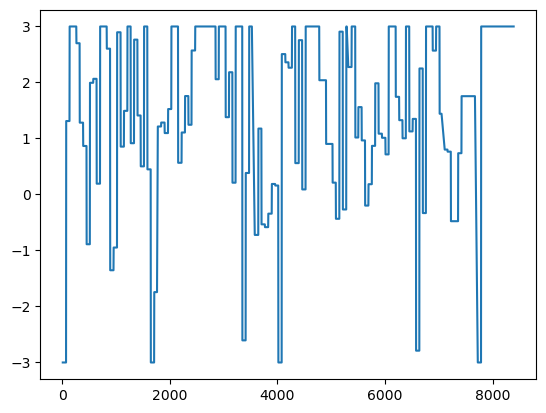

In [153]:
dotcom_price_EPS_data.suescore.plot()

In [86]:
def group_daily_stock_data(company, ticker, sentiment_data_frame, stock_price_data):
    #First lets set up our sentiment data to fill in the whole / lets assume sentiment is consistent until something else is said
    Sentiment_1 = sentiment_data_frame.loc[company]['total_sentiment']

    # Generate a full date range based on the 'rolling_sentiment_Microsoft' index's min and max date
    date_range = pd.date_range(Sentiment_1.index.get_level_values('date').min(), Sentiment_1.index.get_level_values('date').max(), freq='D')
    date_range_df = pd.DataFrame(date_range, columns=['date'])   
    Final_Total_Sentiment = date_range_df.merge(Sentiment_1, how='left', on='date')

    
    Final_Total_Sentiment["total_sentiment"] = Final_Total_Sentiment["total_sentiment"].fillna(0)
    Final_Total_Sentiment.set_index('date', inplace=True)
    Final_Total_Sentiment['total_sentiment'] = Final_Total_Sentiment["total_sentiment"].rolling('5d').sum()
    Rolling_sentiment = Final_Total_Sentiment['total_sentiment'].groupby(Final_Total_Sentiment.index).mean() # for aggregating any multiple sentiment on dates
    Rolling_sentiment = Rolling_sentiment.reset_index()
    
    Rolling_sentiment['date'] = pd.to_datetime(Rolling_sentiment['date'])
    stock_price_data['datadate'] = pd.to_datetime(stock_price_data['datadate'])
    
    # create a copy of stock price data for the ticker
    Prices = stock_price_data[stock_price_data['tic'] == ticker][['datadate', 'prccd']].copy()
    # create a column for daily stock returns
    Prices['daily_return'] = Prices['prccd'].pct_change()

    
    # Merge with rolling sentiment data      
    Stock_data = Rolling_sentiment.merge(Prices.reset_index()[['datadate','daily_return']], how = 'left', left_on = 'date', right_on = 'datadate')
   
    # Final cleanup
    Stock_data.dropna(subset=['daily_return'], inplace=True)
    Stock_data['stock'] = ticker
    Stock_data['company'] = company
    
    Stock_data.set_index('date', inplace=True)

    
    return Stock_data

    

In [87]:
#Now we assign each one to a new data table
MSFT_daily_data = group_daily_stock_data('microsoft', 'MSFT', df_dot_com_affected,dotcom_prices)
CSCO_daily_data = group_daily_stock_data('cisco', 'CSCO', df_dot_com_affected, dotcom_prices)
INTC_daily_data = group_daily_stock_data('intel', 'INTC', df_dot_com_affected, dotcom_prices)
ORCL_daily_data = group_daily_stock_data('oracle', 'ORCL', df_dot_com_affected, dotcom_prices)
WebVan_daily_data = group_daily_stock_data('webvan', 'WBVN', df_dot_com_affected, dotcom_prices)
IPET_daily_data = group_daily_stock_data('pets.com', 'IPET', df_dot_com_affected, dotcom_prices)

ORCL_daily_data.head()

,total_sentiment,datadate,daily_return,stock,company
date,,,,,
1996-02-21,0.8807,1996-02-21,0.021687,ORCL,oracle
1996-02-22,0.8807,1996-02-22,0.021226,ORCL,oracle
1996-02-23,0.8807,1996-02-23,-0.009238,ORCL,oracle
1996-02-26,0.0000,1996-02-26,0.011655,ORCL,oracle
1996-02-27,0.0000,1996-02-27,-0.024184,ORCL,oracle


In [88]:
merged_daily_stock_data = pd.concat([MSFT_daily_data, 
                                     CSCO_daily_data, 
                                     INTC_daily_data, 
                                     ORCL_daily_data, 
                                     WebVan_daily_data,
                                    IPET_daily_data]).reset_index().set_index(['company', 'date'])
dot_com_list = ['microsoft', 'cisco', 'intel', 'oracle', 'webvan', 'pets.com']


def plots(company_list, data_frame): 
    fig, axs = plt.subplots(len(company_list),1, sharex = True, figsize = (10,20))
  
    #Chat gpt  
    if len(company_list) == 1:
        axs = axs
    
    for i, company in enumerate(company_list):
        ax1 = axs[i]

        company_data = data_frame.loc[company].reset_index()
        
        line1,  = ax1.plot(company_data['date'], company_data['total_sentiment'], color = 'green', label = 'Sentiment')
        ax1.set_xlabel('date')
        ax1.set_ylabel('Sentiment')

        ax2 = ax1.twinx()
        line2,  = ax2.plot(company_data['date'], company_data['daily_return'], color = 'blue', label = 'Stock Price', alpha = 0.5)
        ax2.set_ylabel('Stock Price')   

        # Align the 0 on both y-axes
        sentiment_min = company_data['total_sentiment'].min()
        sentiment_max = company_data['total_sentiment'].max()
        return_min = company_data['daily_return'].min()
        return_max = company_data['daily_return'].max()

        sentiment_range = max(abs(sentiment_min)+.1, abs(sentiment_max)+.1)
        return_range = max(abs(return_min)+.1, abs(return_max)+.1)

        ax1.set_ylim(-sentiment_range, sentiment_range)
        ax2.set_ylim(-return_range, return_range)
        
        plt.title(f'{company} : Stock Price and Sentiment Over Time')
        ax1.legend(handles = [line1, line2], labels = ['Sentiment', 'Stock Price'], loc='upper left')
        ax1.set_facecolor((0, 0, 0, 0.05)) 
    plt.tight_layout()

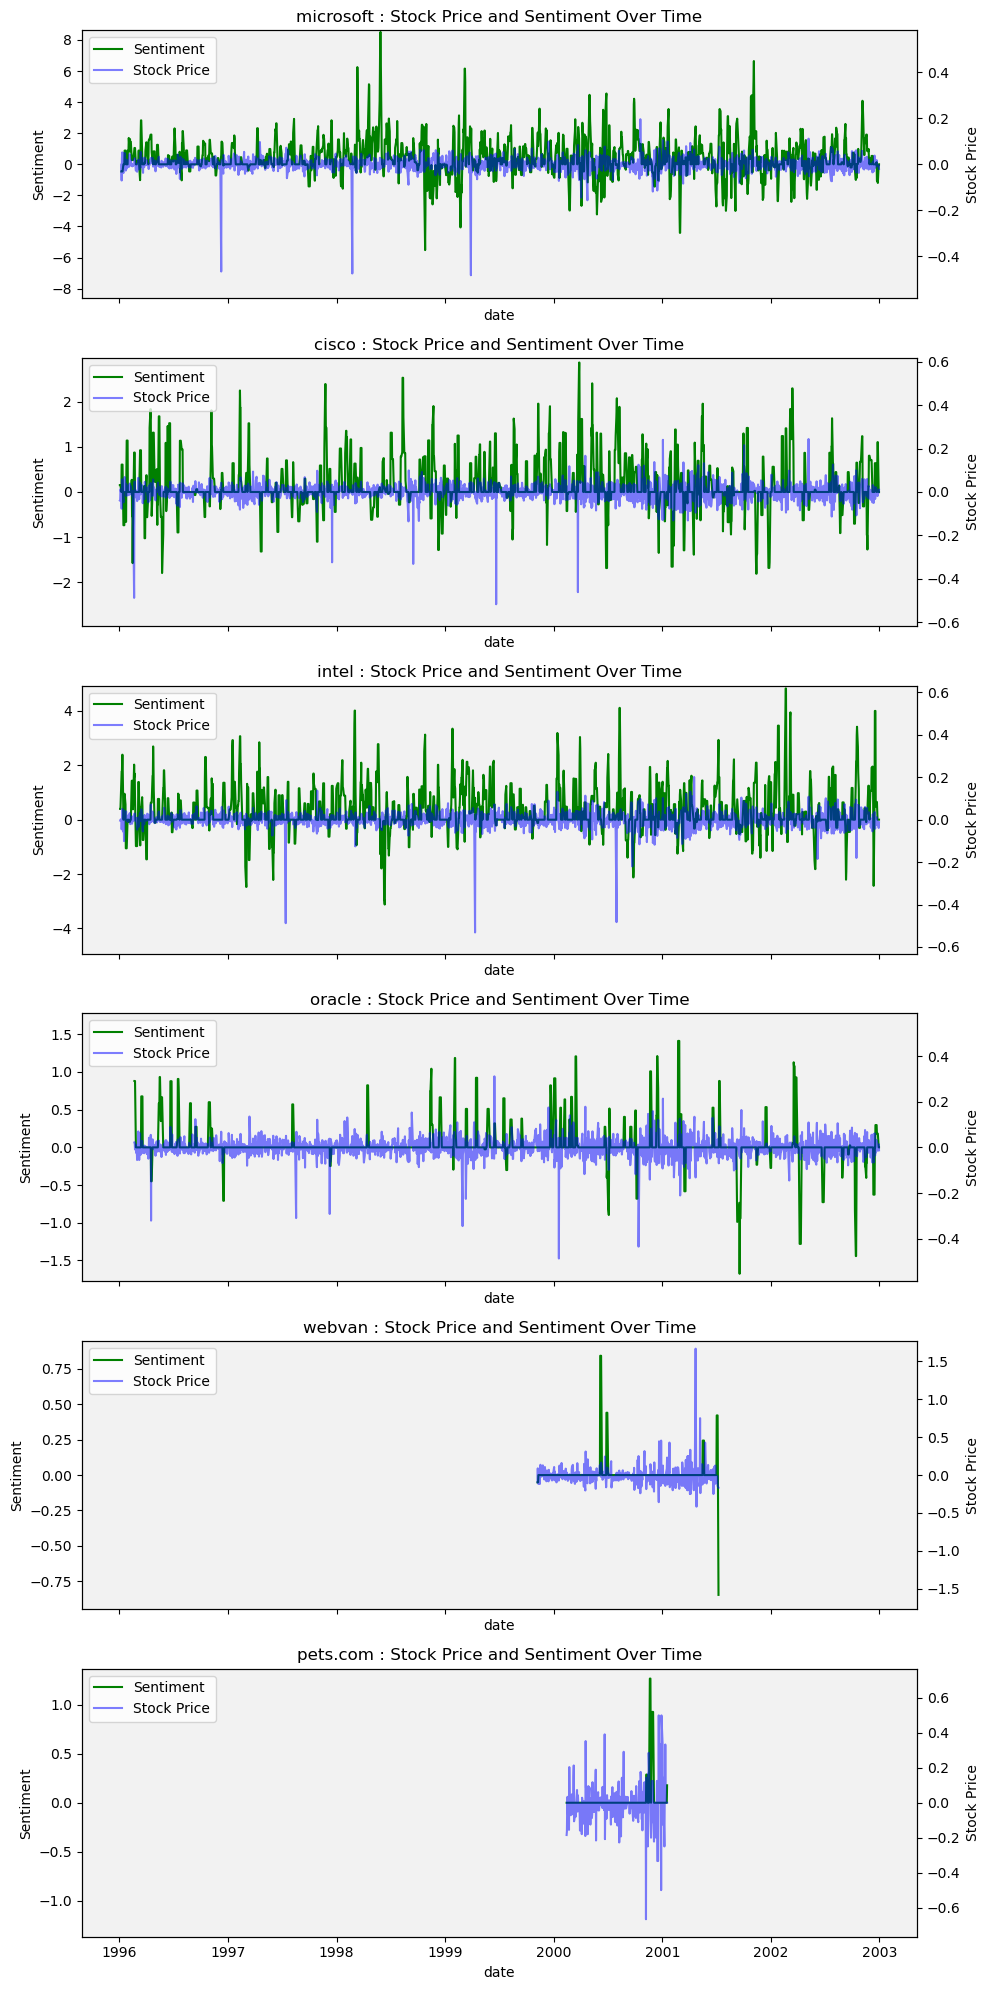

In [89]:
plots(dot_com_list, merged_daily_stock_data)
#lets plot the afected dot com stocks and see if there exists a potential relationship between the variables
#mentioend the potential circulairty of sentiment and stock prices 
#talk about the smoothing/  why we chose that rolling time frame, that there seems to be a relationship and worth investigating further with a VAR analysis

Now lets run some regressions on each data piece and stock. For sentiment we will use the rolling average to avoid all the noise. We decided that using another statistical measure such as a Z score wouldn't give us the right information since we are less worries about when sentiment deviates from the mean but more about the direction of sentiment in each time frame.  
EDIT THIS DONT LEAVE

This definetley goes to show that there is a relationship between sentiment and stock price but at the same time stock price can lead higher sentiment 
This goes to prove the reflexivie relationship 

In [93]:
 # prepare the dates index
# dates = mdata[['year', 'quarter']].astype(int).astype(str)
# quarterly = dates["year"] + "Q" + dates["quarter"]
# quarterly = dates_from_str(quarterly)

# mdata1 = mdata[['realgdp', 'cpi', 'unemp', 'infl']]
# CSCO_daily_data.index = pd.DatetimeIndex
# data = data.asfreq("D")

def make_var_model(data, lags = 10, actual_plot = False):
 
    # make a VAR model
    model = VAR(data)
    
    result_dict = {}
        
    for lag in range(1, lags+1):
        #Fitting Model
        results = model.fit(maxlags = lag)
        
        lag_order = results.k_ar
        
        print ('Exogenous Variables for the model with Lag: %d \n '%lag+ str(results.exog_names))
        print (results.summary())
        
        #Generating Model output
        fitted_values = results.fittedvalues
        forecast_values = pd.DataFrame(data = results.forecast(y= data.values[-lag_order:], steps=  5), columns = results.names)
        results.forecast_interval(y= data.values[-lag_order:], steps = 10)
        
        results.plot_forecast(steps = 10, plot_stderr = True)
        
        if actual_plot ==True:
            results.plot()

In [176]:
def make_var_model(data, max_lags=10, actual_plot=False):
    data = data.asfreq('D').ffill()

    model = VAR(data)
    
    # Select optimal lag using AIC
    lag_selection = model.select_order(maxlags=max_lags)
    optimal_lag = lag_selection.aic
    
    print(f"Optimal lag selected by AIC: {optimal_lag}")
    
    # Fit the VAR model using optimal lag
    results = model.fit(optimal_lag)
    
    print('Exogenous Variables for the model with Lag:', optimal_lag)
    print(results.exog_names)
    print(results.summary())
    
    # Forecasting
    lag_order = results.k_ar
    fitted_values = results.fittedvalues
    forecast_values = pd.DataFrame(
        data=results.forecast(y=data.values[-lag_order:], steps=5),
        columns=results.names
    )
    
    # # Plotting
    # results.plot_forecast(steps=90, plot_stderr=True)
    
    # if actual_plot:
    #     results.plot()

    return results, forecast_values

In [113]:
# CSCO_daily_data = CSCO_daily_data.asfreq('D')
results, forecast_df = make_var_model(CSCO_daily_data[["daily_return", "total_sentiment"]], actual_plot=False)


Optimal lag selected by AIC: 6
Exogenous Variables for the model with Lag: 6
['const', 'L1.daily_return', 'L1.total_sentiment', 'L2.daily_return', 'L2.total_sentiment', 'L3.daily_return', 'L3.total_sentiment', 'L4.daily_return', 'L4.total_sentiment', 'L5.daily_return', 'L5.total_sentiment', 'L6.daily_return', 'L6.total_sentiment']
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Apr, 2025
Time:                     00:01:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.61403
Nobs:                     2549.00    HQIC:                  -8.65202
Log likelihood:           3846.80    FPE:                0.000171036
AIC:                     -8.67364    Det(Omega_mle):     0.000169305
--------------------------------------------------------------------
Results for equation daily_return
                        coefficient       st

In [114]:
results_WBVN, forecast_WBVN = make_var_model(WebVan_daily_data[["daily_return", "total_sentiment"]], actual_plot=False)

Optimal lag selected by AIC: 7
Exogenous Variables for the model with Lag: 7
['const', 'L1.daily_return', 'L1.total_sentiment', 'L2.daily_return', 'L2.total_sentiment', 'L3.daily_return', 'L3.total_sentiment', 'L4.daily_return', 'L4.total_sentiment', 'L5.daily_return', 'L5.total_sentiment', 'L6.daily_return', 'L6.total_sentiment', 'L7.daily_return', 'L7.total_sentiment']
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Apr, 2025
Time:                     00:02:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.25855
Nobs:                     603.000    HQIC:                  -9.39231
Log likelihood:           1176.24    FPE:                7.65531e-05
AIC:                     -9.47755    Det(Omega_mle):     7.28820e-05
--------------------------------------------------------------------
Results for equation daily_return
   

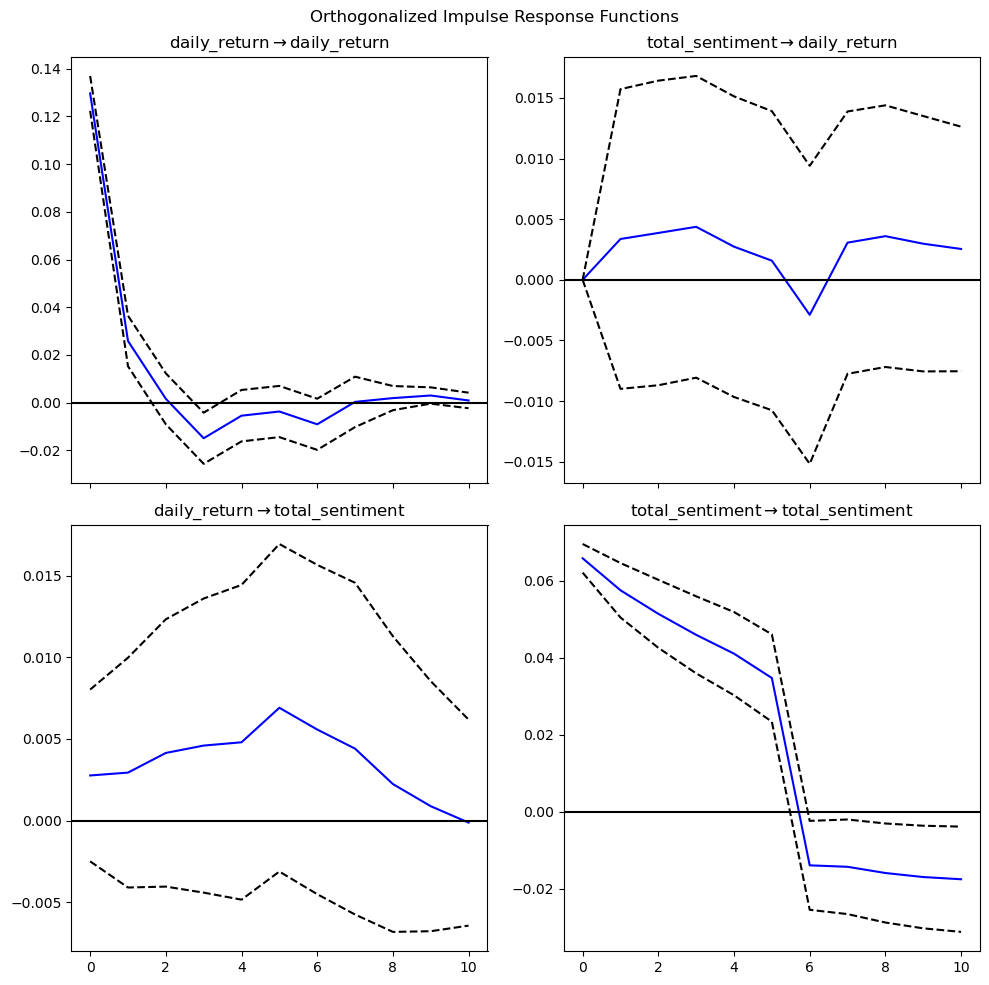

In [115]:
# Create impulse response function object
irf_WBVN = results_WBVN.irf(10)  # 10-step ahead IRF

# Plot orthogonalized IRFs
irf_WBVN.plot(orth=True)
plt.suptitle("Orthogonalized Impulse Response Functions")
plt.tight_layout()


lets assign some variables now 

In [188]:
# saru's version
def sentiment_stock_EPS_data(company, ticker, sentiment_data_frame, price_EPS_data):
    # First lets set up our sentiment data to fill in the whole / lets assume sentiment is consistent until something else is said
    Sentiment_1 = sentiment_data_frame.loc[company]['total_sentiment']

    date_range = pd.date_range(Sentiment_1.index.get_level_values('date').min(), Sentiment_1.index.get_level_values('date').max(), freq='D')
    date_range_df = pd.DataFrame(date_range, columns=['date'])
    Final_Total_Sentiment = date_range_df.merge(Sentiment_1, how='left', on='date')

    Final_Total_Sentiment["total_sentiment"] = Final_Total_Sentiment["total_sentiment"].fillna(0)
    Final_Total_Sentiment.set_index('date', inplace=True)
    Final_Total_Sentiment['total_sentiment'] = Final_Total_Sentiment["total_sentiment"].rolling('5d').sum()
    Rolling_sentiment = Final_Total_Sentiment['total_sentiment'].groupby(Final_Total_Sentiment.index).mean() # for aggregating any multiple sentiment on dates
    Rolling_sentiment = Rolling_sentiment.reset_index()

    Rolling_sentiment['date'] = pd.to_datetime(Rolling_sentiment['date'])
    price_EPS_data['datadate'] = pd.to_datetime(price_EPS_data['datadate'])

    # create a copy of stock price data for the ticker
    prices_EPS = price_EPS_data[price_EPS_data['tic'] == ticker][['datadate', 'prccd', 'suescore']].copy()
    # create a column for daily stock returns
    prices_EPS['daily_return'] = prices_EPS['prccd'].pct_change()

    #Now lets get ready to merge this data set with its earnings suprise data 
    Stock_data =  Rolling_sentiment.merge(prices_EPS.reset_index()[['datadate','daily_return','suescore']], how = 'left', left_on = "date", right_on = "datadate")
   
    # Final cleanup
    Stock_data.dropna(subset=['daily_return', 'suescore'], inplace=True)
    Stock_data['stock'] = ticker
    Stock_data['company'] = company

    Stock_data.set_index('date', inplace=True)
    
    return Stock_data

In [149]:
dotcom_price_EPS_data.head()

,datadate,tic,conm,prccd,anndats,suescore
10,1996-01-16,INTC,INTEL CORP,55.750,1996-01-16,-3.0
11,1996-01-17,INTC,INTEL CORP,50.125,1996-01-16,-3.0
12,1996-01-18,INTC,INTEL CORP,51.000,1996-01-16,-3.0
13,1996-01-19,INTC,INTEL CORP,51.375,1996-01-16,-3.0
14,1996-01-22,INTC,INTEL CORP,52.000,1996-01-16,-3.0


In [460]:
#NOte that for the dot com data set we couldn't use EPS suprise bc of limited data so are chooisng to use EPS growth as measure of fundamental however EPS suprise would have given us better information about a change in fundamentals no expected by the market 

In [189]:
MSFT_daily_wEPS = sentiment_stock_EPS_data('microsoft', 'MSFT',df_dot_com_affected, dotcom_price_EPS_data)
CSCO_daily_wEPS = sentiment_stock_EPS_data('cisco', 'CSCO', df_dot_com_affected, dotcom_price_EPS_data)
INTC_daily_wEPS = sentiment_stock_EPS_data('intel', 'INTC', df_dot_com_affected, dotcom_price_EPS_data)
ORCL_daily_wEPS = sentiment_stock_EPS_data('oracle', 'ORCL', df_dot_com_affected, dotcom_price_EPS_data)
WebVan_daily_wEPS = sentiment_stock_EPS_data('webvan', 'WBVN', df_dot_com_affected, dotcom_price_EPS_data)
IPET_daily_wEPS = sentiment_stock_EPS_data('pets.com', 'IPET', df_dot_com_affected, dotcom_price_EPS_data)

CSCO_daily_wEPS.head()

,total_sentiment,datadate,daily_return,suescore,stock,company
date,,,,,,
1996-02-09,0.0000,1996-02-09,0.026723,2.27577,CSCO,cisco
1996-02-12,0.2690,1996-02-12,-0.013699,2.27577,CSCO,cisco
1996-02-13,-0.5357,1996-02-13,0.002778,2.27577,CSCO,cisco
1996-02-14,-0.5357,1996-02-14,-0.019391,2.27577,CSCO,cisco
1996-02-15,-1.5723,1996-02-15,0.004949,2.27577,CSCO,cisco


In [173]:
merged_stock_wEPS_data = pd.concat([MSFT_daily_wEPS, CSCO_daily_wEPS, INTC_daily_wEPS, ORCL_daily_wEPS, WebVan_daily_wEPS, IPET_daily_wEPS]
                                       ).reset_index().set_index(['company', 'date'])
dot_com_list = ['microsoft', 'cisco', 'intel', 'oracle', 'webvan', 'pets.com']

def plots_wEPS(company_list, data_frame): 
    fig, axs = plt.subplots(len(company_list),1, sharex = True, figsize = (10,20))
    
    if len(company_list) == 1:
        axs = axs

    for i, company in enumerate(company_list):
        ax1 = axs[i]

        company_data = data_frame.loc[company].reset_index()
        
        line1,  = ax1.plot(company_data['date'], company_data['total_sentiment'], color = 'green', label = 'Sentiment')
        line2,  = ax1.plot(company_data['date'], company_data['suescore'], color = 'purple', label = 'EPS_surprise')
        
        ax1.set_xlabel('date')
        ax1.set_ylabel('Sentiment / EPS Surprise')

        ax2 = ax1.twinx()
        line3,  = ax2.plot(company_data['date'], company_data['daily_return'], color = 'blue', label = 'Stock Price', alpha = 0.5)
        ax2.set_ylabel('Stock Price Daily Return')   

        # Align the 0 on both y-axes
        sentiment_min = company_data['total_sentiment'].min()
        sentiment_max = company_data['total_sentiment'].max()
        EPS_min = company_data['suescore'].min()
        EPS_max = company_data['suescore'].max()
        return_min = company_data['daily_return'].min()
        return_max = company_data['daily_return'].max()

        sentiment_range = max(abs(sentiment_min)+.1, abs(sentiment_max)+.1, abs(EPS_min)+.1, abs(EPS_max)+.1)
        return_range = max(abs(return_min)+.1, abs(return_max)+.1)

        ax1.set_ylim(-sentiment_range, sentiment_range)
        ax2.set_ylim(-return_range, return_range)



        
        plt.title(f'{company.capitalize()} : Sentiment score, stock price daily returns and EPS surprise over time')
        ax1.legend(handles = [line1, line2, line3], labels = ['Sentiment', 'EPS Surprise', 'Stock Price'], loc='upper right')
        axs[i].set_facecolor((0,0,0,0.05))
    plt.tight_layout()
    

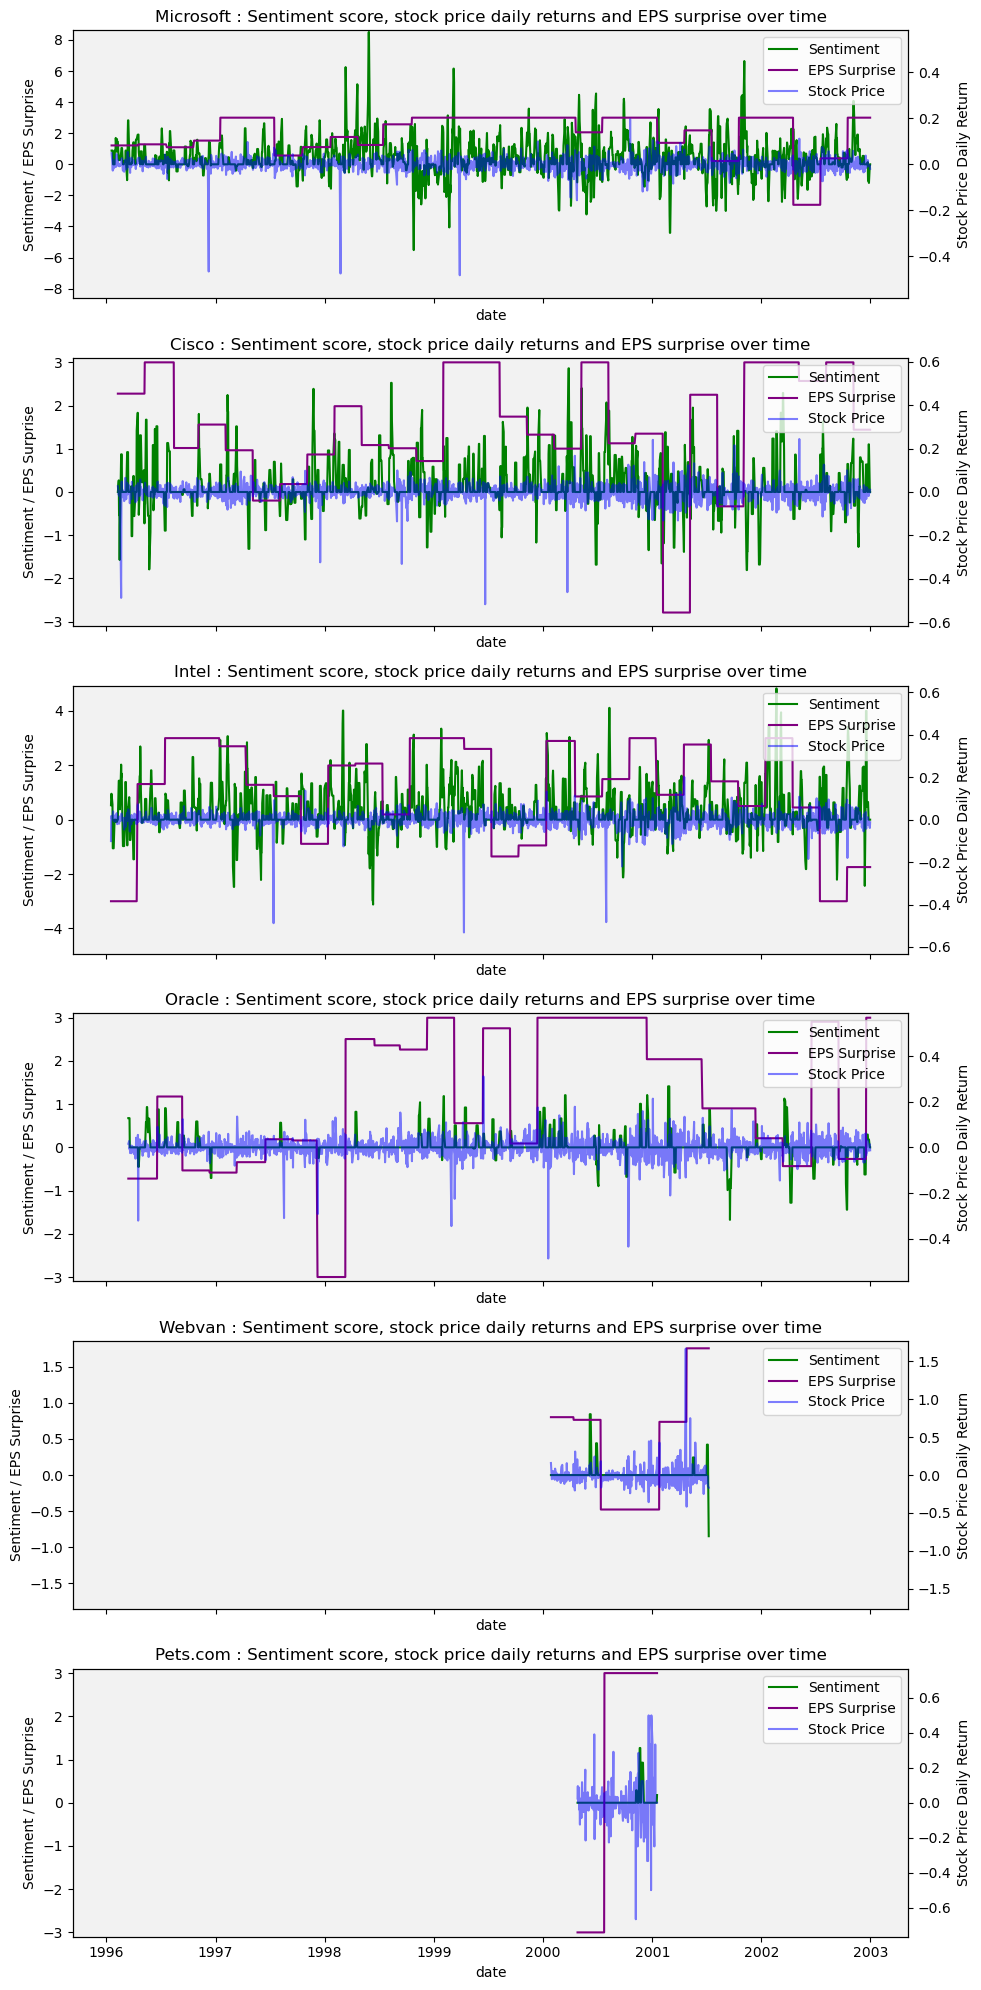

In [174]:
plots_wEPS(dot_com_list, merged_stock_wEPS_data)
#lets see what follow what by the pictures
#Talk here about how we see a relationship worth investigating further, some observations on what we think is leading what 

In [195]:
results_CSCO_wEPS, forecast_CSCO_wEPS = make_var_model(CSCO_daily_wEPS[["daily_return", "total_sentiment", "suescore"]],max_lags=10, actual_plot=False)

Optimal lag selected by AIC: 6
Exogenous Variables for the model with Lag: 6
['const', 'L1.daily_return', 'L1.total_sentiment', 'L1.suescore', 'L2.daily_return', 'L2.total_sentiment', 'L2.suescore', 'L3.daily_return', 'L3.total_sentiment', 'L3.suescore', 'L4.daily_return', 'L4.total_sentiment', 'L4.suescore', 'L5.daily_return', 'L5.total_sentiment', 'L5.suescore', 'L6.daily_return', 'L6.total_sentiment', 'L6.suescore']
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 20, Apr, 2025
Time:                     01:04:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.8979
Nobs:                     2512.00    HQIC:                  -11.9822
Log likelihood:           4473.82    FPE:                5.96140e-06
AIC:                     -12.0302    Det(Omega_mle):     5.82815e-06
---------------------------------------------------------

In [196]:
def current_news (ticker):

    url = f'https://finance.yahoo.com/quote/{ticker}/latest-news/'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    response = requests.get(url, headers = headers)

    if not response.ok:
        print('Status code:', response.status_code)
        raise Exception('Failed to load page {}'.format(url))
        
    page_content = response.text
    doc = BeautifulSoup(page_content, 'html.parser')

    headlines = doc.find_all('h3', class_='clamp yf-82qtw3')
    descriptions = doc.find_all('p', class_ = 'clamp yf-82qtw3')
    dates = doc.find_all('div', class_ = 'footer yf-82qtw3')
    

    articles = [{"headline" : headline.get_text(), "description" : description.get_text(), "date" : date.get_text()} for headline, description, date in zip(headlines,descriptions, dates)]

    current_company_news = pd.DataFrame(articles)

    formatted_dates = []
    #Must deal with minutes, yesterday, last month 
    for text in current_company_news['date']:
        match = re.search(r'(\d+)\s*(minutes|minute|days?|months?)\s*ago', text)

        if match:
            number = int(match.group(1))
            unit = match.group(2)

            if "minute" in text:
                extracted_date = datetime.today() - timedelta(minutes=number)
            
            elif unit.startswith('d'):
                extracted_date = datetime.today() - timedelta(days=number)
                
            elif unit.startswith('m'):
                extracted_date = datetime.today() - timedelta(days=number *30)
                
            elif "yesterday" in text:
                extracted_date = datetime.today() - timedelta(days=1)
    
            elif "last month" in text:
                extracted_date = datetime.today() - timedelta(days=30)

        else:  
            extracted_date = datetime(1900,1,1)
            
        formatted_date = extracted_date.strftime('%Y-%m-%d') 
       
        formatted_dates.append(formatted_date)

    current_company_news ['date'] = formatted_dates
    current_company_news.set_index('date', inplace = True)

    current_company_news['headline_sentiment'] = [analyzer.polarity_scores(headline)['compound'] for headline in current_company_news['headline']]
    current_company_news['description_sentiment'] = [analyzer.polarity_scores(description)['compound'] for description in current_company_news['description']]
    print(url)
    return current_company_news

In [197]:
# More recent data in last 20 years 
#This is a quicker code, use when need data more recent
API_KEY = "5dFCYxrxkU5dAwxWIqWwyi7FfNTIQpzG"
analyzer = SentimentIntensityAnalyzer()

def Recent_News_NYT(company_list, start_date, end_date):
    # dates must be in form yyyymmdd
    articles = []

    
    for company in company_list:
        for i in range(0, 10):  # NYT API paginates starting at 0

            url = (
                f"https://api.nytimes.com/svc/search/v2/articlesearch.json?"
                f"q={company}&"
                f"begin_date={start_date}&end_date={end_date}&"
                f"page={i}&"
                f"api-key={API_KEY}"
            )
        
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Error {response.status_code}: {response.text}")
                continue

            data = response.json()
            for article in data.get("response", {}).get("docs", []):
                headline = article.get("headline", {}).get("main", "")
                pub_date = article.get("pub_date", "")
                description = article.get("abstract") or article.get("lead_paragraph", "")

                articles.append({
                    "headline": headline,
                    "date": pub_date,
                    "description": description,
                    "stock": company
                })

            time.sleep(12)

    company_news_df = pd.DataFrame(articles)
    if company_news_df.empty:
        print("No articles found.")
        return pd.DataFrame()

    company_news_df['date'] = pd.to_datetime(company_news_df['date'])
    #.dt.strftime('%Y-%m-%d')
    company_news_df.set_index(['stock', 'date'], inplace=True)

    # Sentiment analysis
    company_news_df['headline_sentiment'] = company_news_df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    company_news_df['description_sentiment'] = company_news_df['description'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    company_news_df['total_sentiment'] = company_news_df['headline_sentiment'] + company_news_df['description_sentiment']

    return company_news_df


In [ ]:
company_list = ['goldman sachs', 'morgan stanley', 'jp morgan', 'bank of america', 'ubs']
Financial_crisis = Recent_News_NYT(company_list, '20070101', '20110101')
#print to a date file
Financial_crisis.to_pickle("Financial_crisis.pkl")
#Don't un hashtag - this code just saved it to a pickle data file
Financial_crisis_df = pd.read_pickle("Financial_crisis.pkl")
Financial_crisis_df.index = Financial_crisis_df.index.set_levels(
    pd.to_datetime(Financial_crisis_df.index.levels[1]),
    level='date')
Financial_crisis_df['stock'] = df['stock'].replace('UBS', 'ubs')

In [ ]:
FC_EPS = pd.read_csv("fin2008_EPS.csv")
FC_stock_prices = pd.read_csv("fin2008_prices.csv")

FC_stock_prices["tic"] = FC_stock_prices["tic"].replace({"OUBSF": "UBS"})
fin2008_tickers = ['JPM', 'BAC', 'MS', 'GS', 'UBS']
FC_stock_prices = FC_stock_prices[FC_stock_prices["tic"].isin(fin2008_tickers)]

FC_EPS["anndats"] = pd.to_datetime(FC_EPS["anndats"], format = date_format)
FC_stock_prices["datadate"] = pd.to_datetime(FC_stock_prices["datadate"], format = date_format)

FC_price_EPS_data = create_EPS_price(FC_stock_prices, FC_EPS)

In [ ]:
JPM_daily_df = group_daily_stock_data('jp morgan', 'JPM', Financial_crisis_df, FC_stock_prices)
BAC_daily_df = group_daily_stock_data('bank of america', 'BAC', Financial_crisis_df, FC_stock_prices)
GS_daily_df = group_daily_stock_data('goldman sachs', 'GS', Financial_crisis_df, FC_stock_prices)
MS_daily_df = group_daily_stock_data('morgan stanley', 'MS', Financial_crisis_df, FC_stock_prices)
UBS_daily_df = group_daily_stock_data('ubs', 'UBS', Financial_crisis_df, FC_stock_prices)

C:\Users\2211s\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\2211s\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\2211s\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\2211s\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

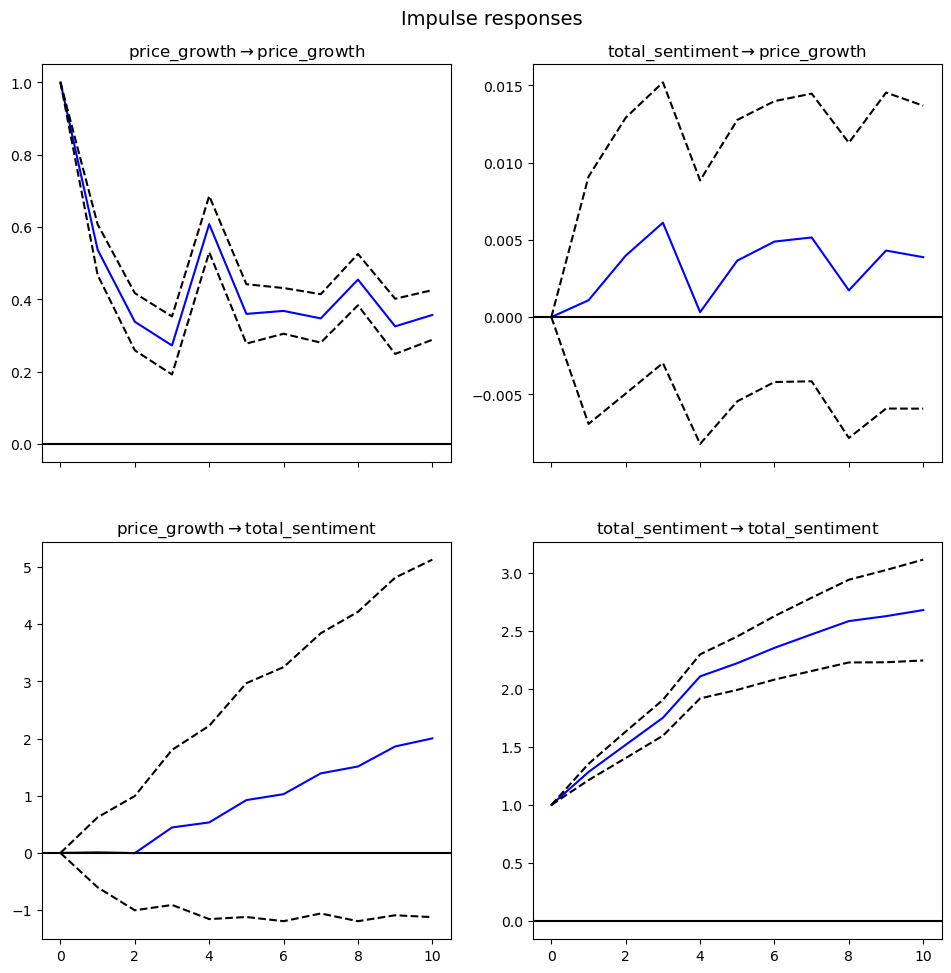

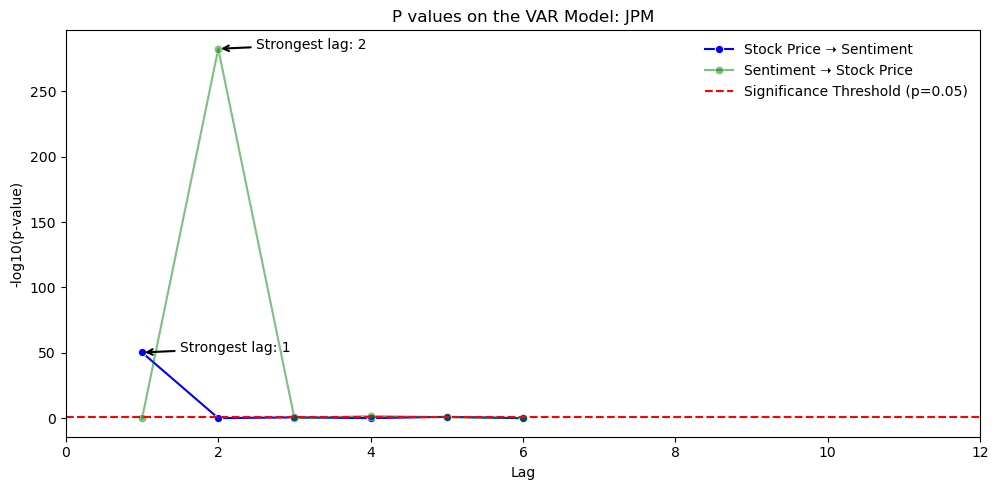

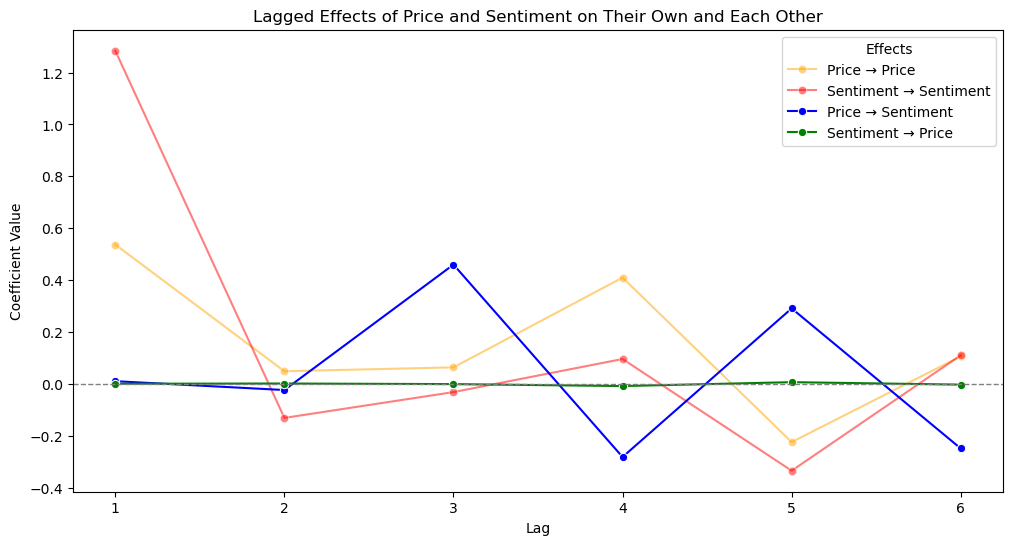

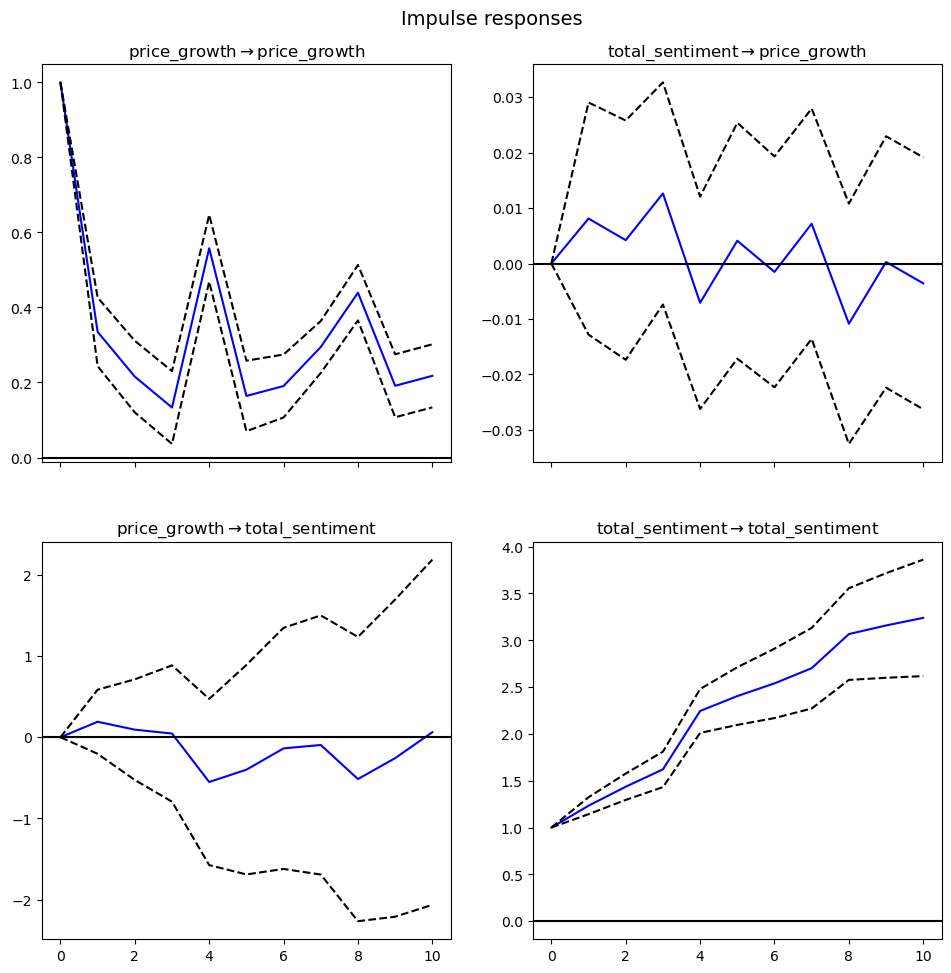

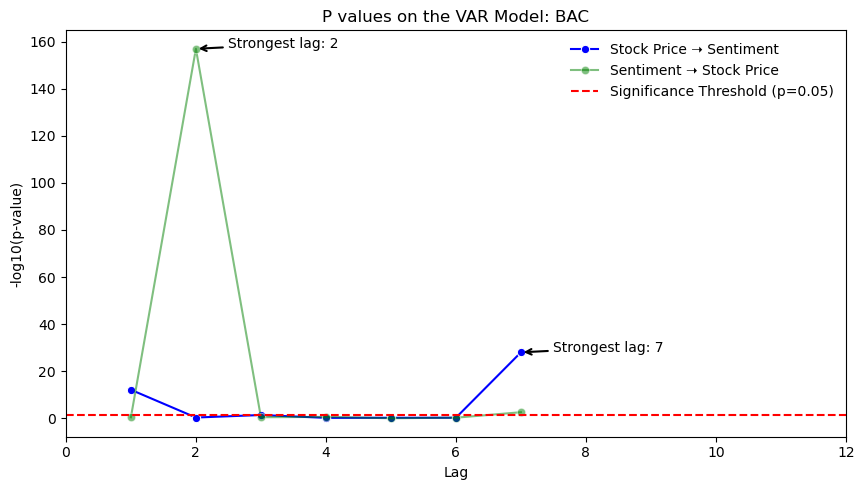

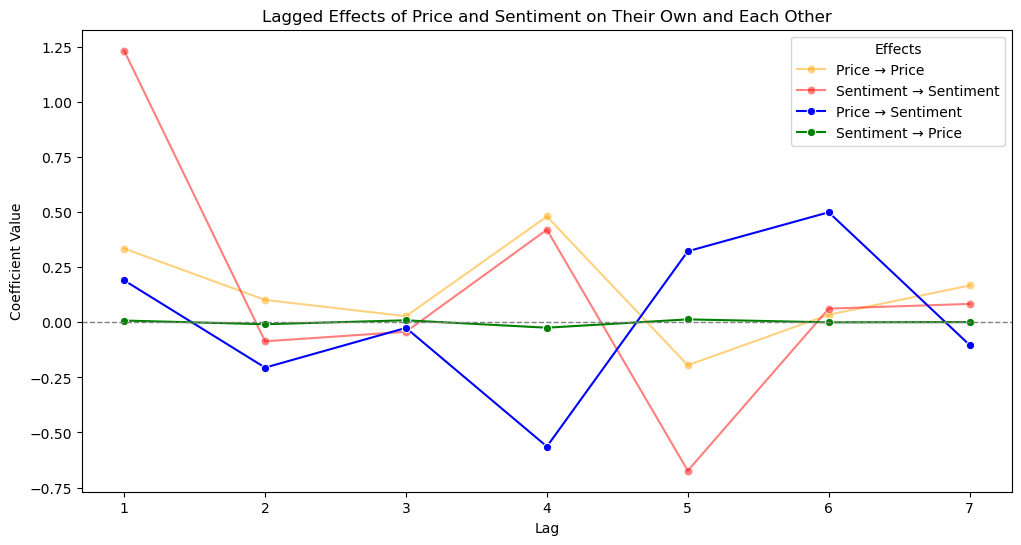

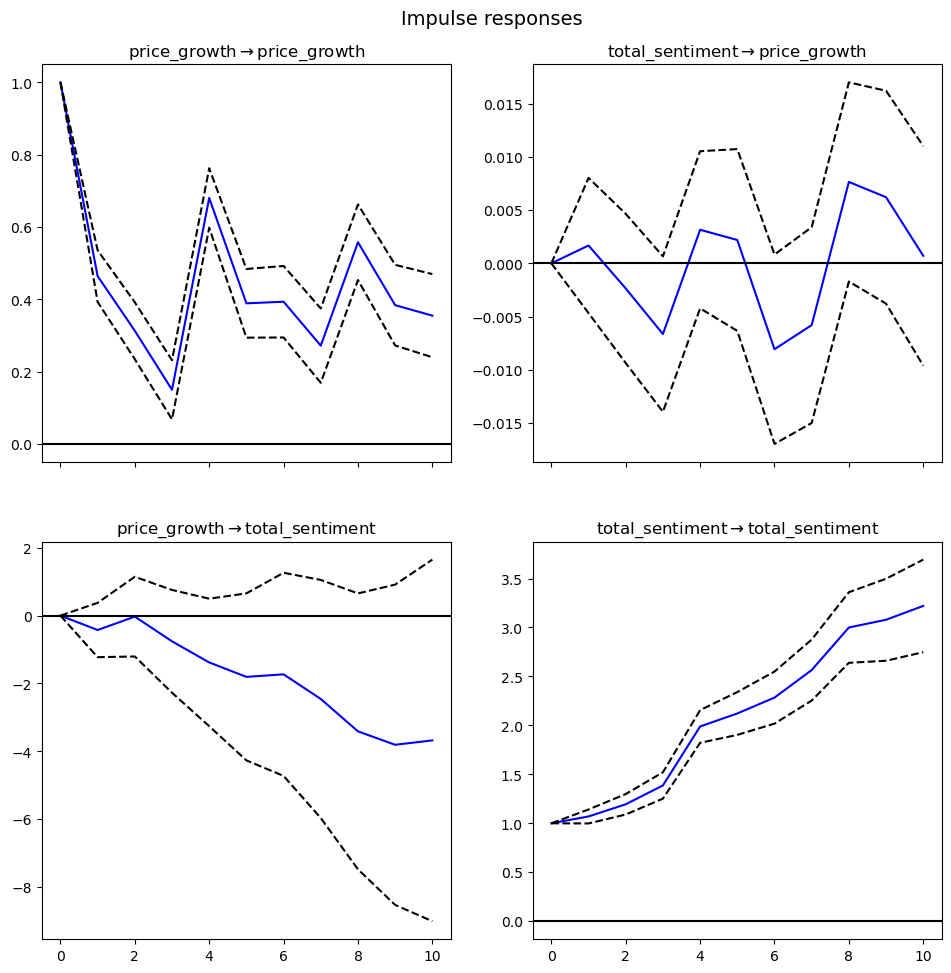

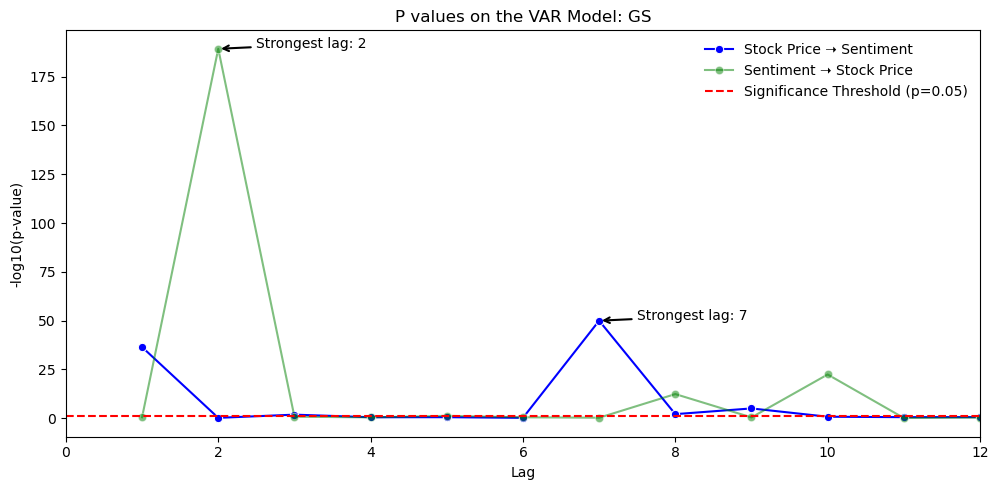

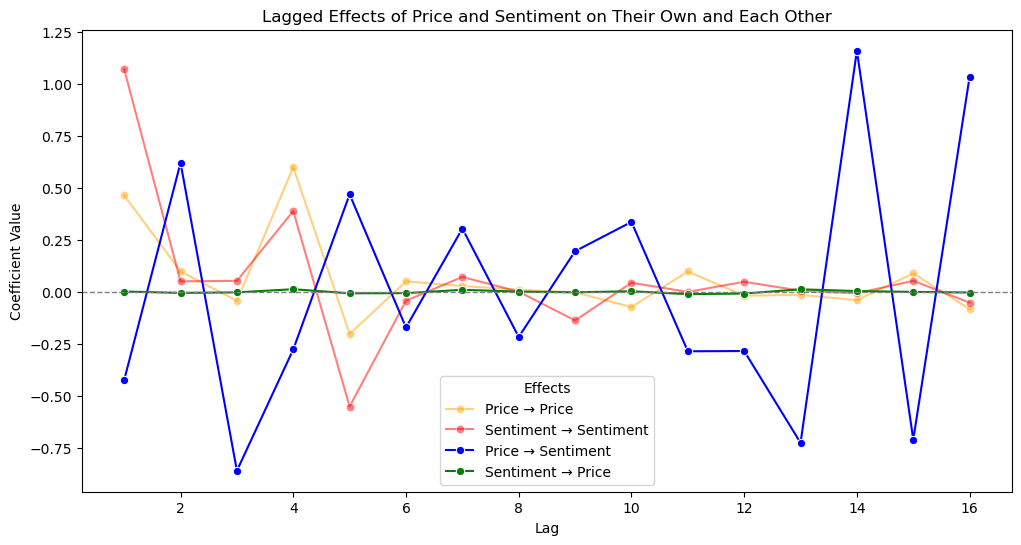

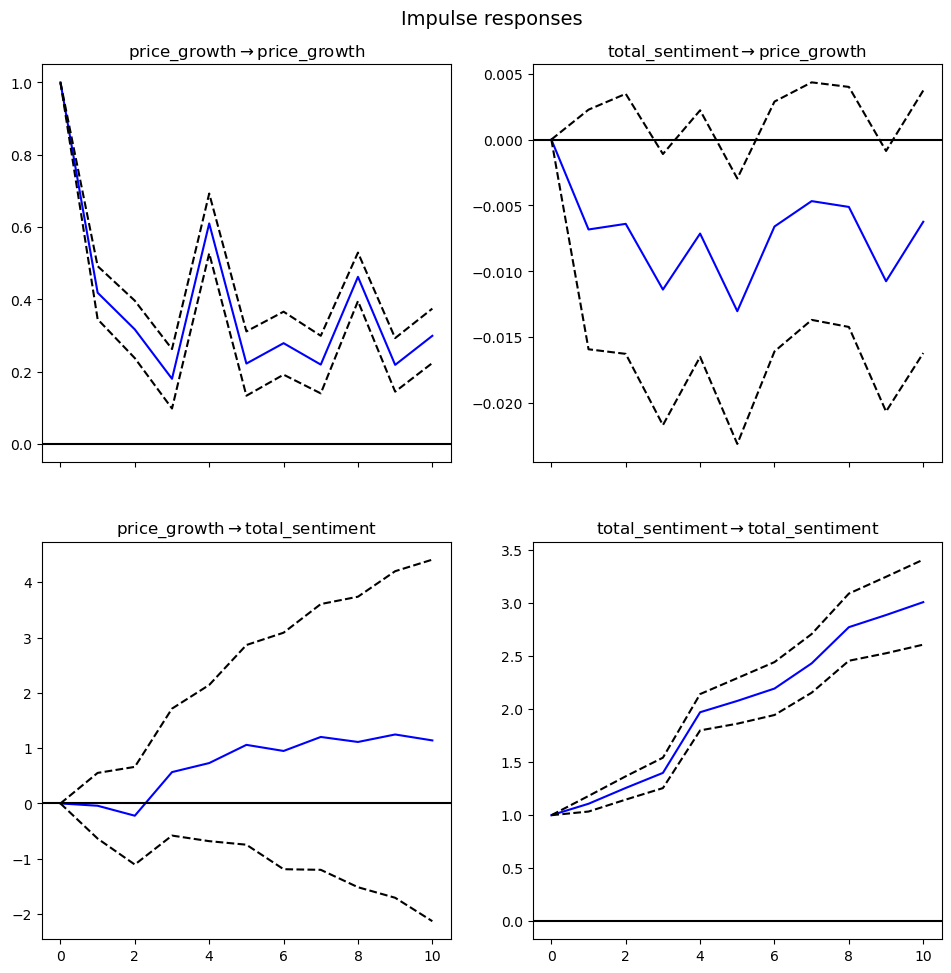

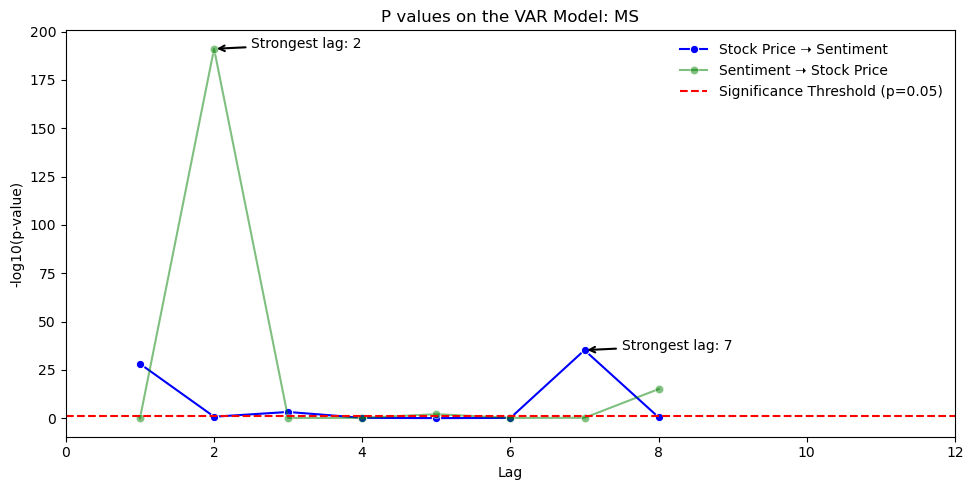

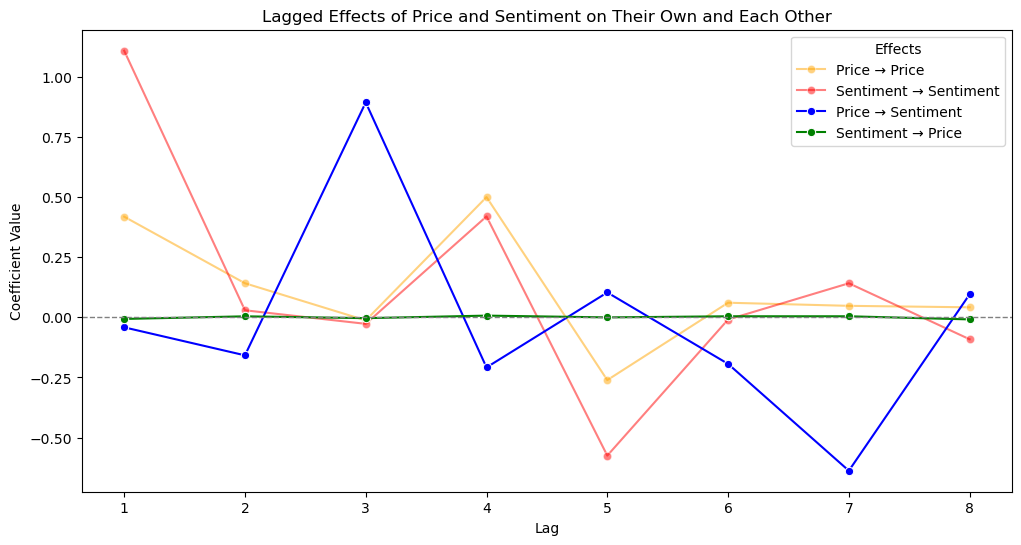

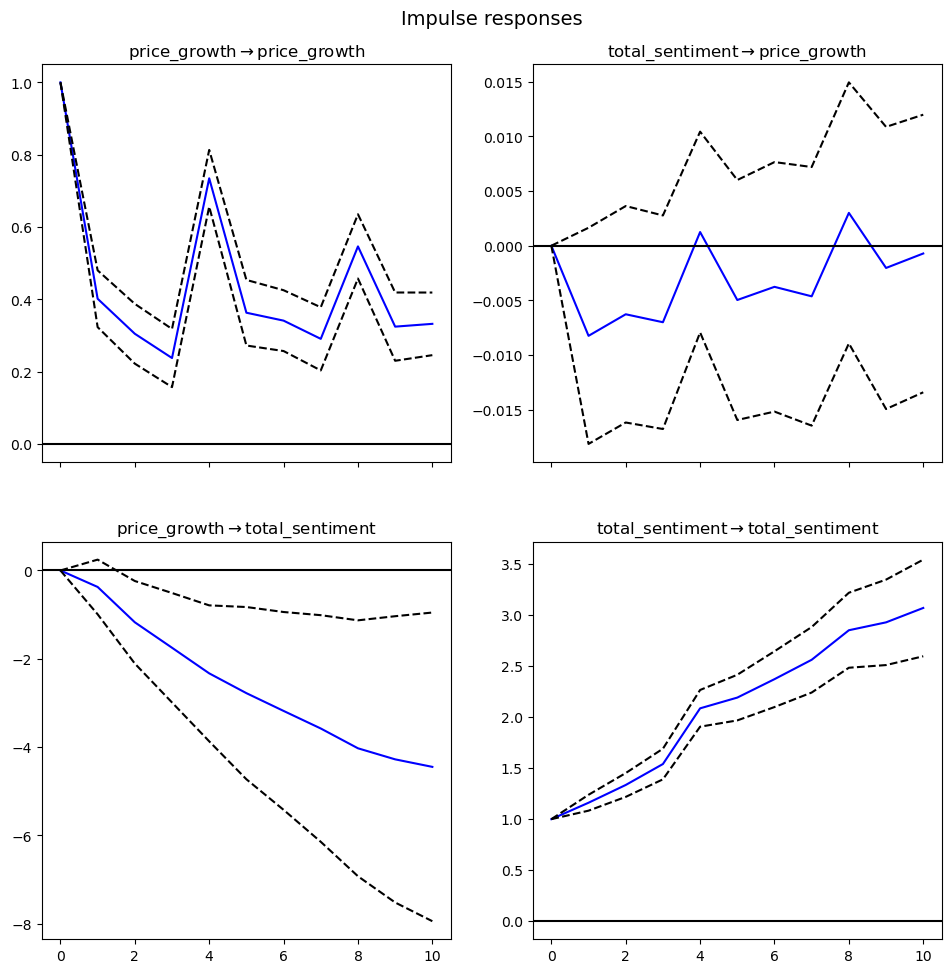

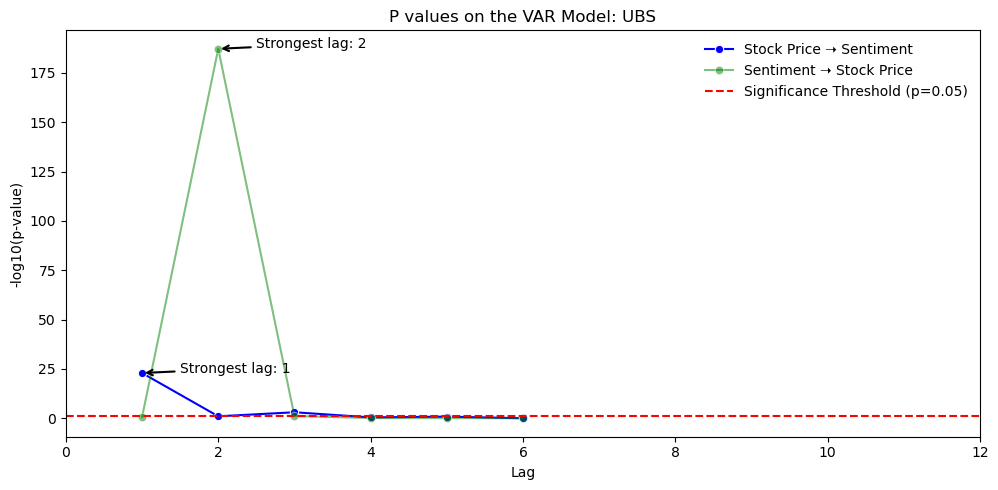

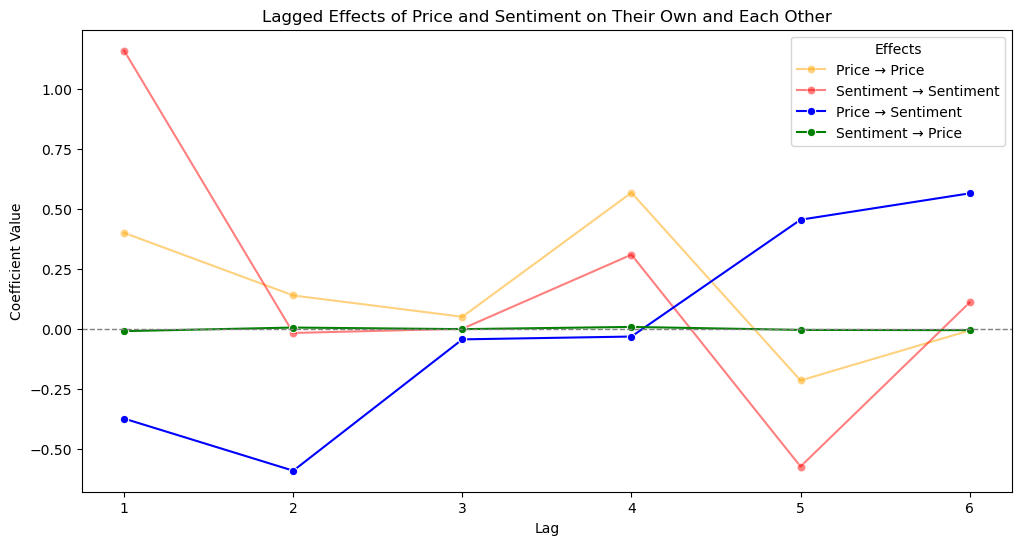

In [180]:
JPM_p_values, JPM_Coeffs = P_value_Chart_PriceandSentiment_VAR(JPM_daily_df, 'JPM')
BAC_p_values, BAC_Coeffs = P_value_Chart_PriceandSentiment_VAR(BAC_daily_df, 'BAC')
GS_p_values, GS_Coeffs = P_value_Chart_PriceandSentiment_VAR(GS_daily_df, 'GS')
MS_p_values, MS_Coeffs = P_value_Chart_PriceandSentiment_VAR(MS_daily_df, 'MS')
UBS_p_values, UBS_Coeffs = P_value_Chart_PriceandSentiment_VAR(UBS_daily_df, 'UBS')


In [184]:
JPM_quarterly = quarterly_stock_data('jp morgan', 'JPM',Financial_crisis_df, FC_EPS, FC_stock_prices)
BAC_quarterly = quarterly_stock_data('bank of america', 'BAC',Financial_crisis_df, FC_EPS, FC_stock_prices)
GS_quarterly = quarterly_stock_data('goldman sachs', 'GS',Financial_crisis_df, FC_EPS, FC_stock_prices)
MS_quarterly = quarterly_stock_data('morgan stanley', 'MS',Financial_crisis_df, FC_EPS, FC_stock_prices)
UBS_quarterly = quarterly_stock_data('ubs', 'UBS',Financial_crisis_df, FC_EPS, FC_stock_prices)

C:\Users\2211s\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\2211s\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\2211s\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\2211s\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\22

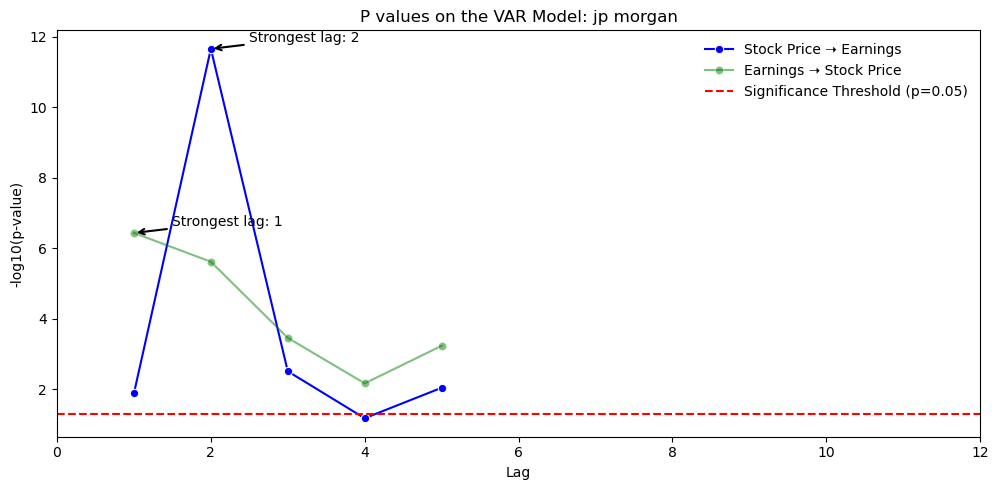

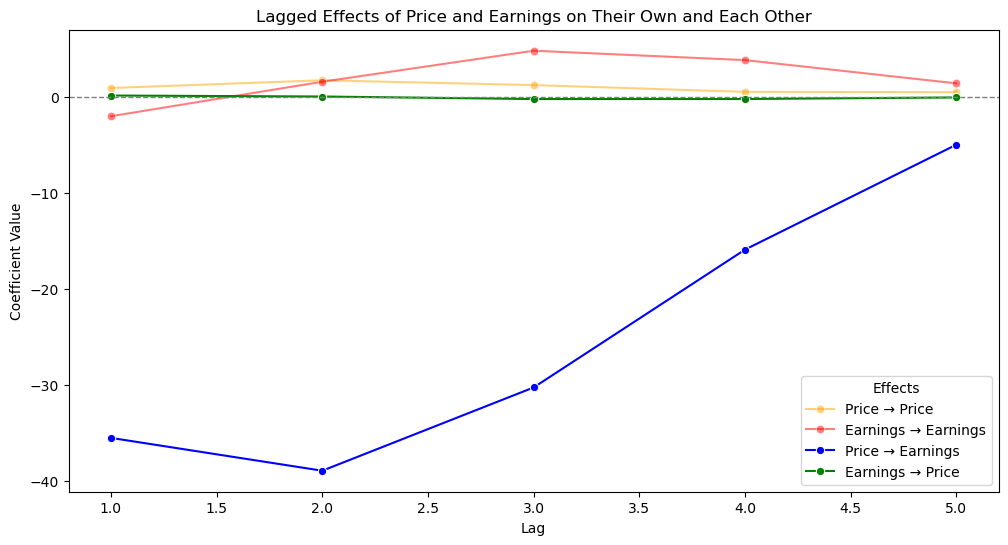

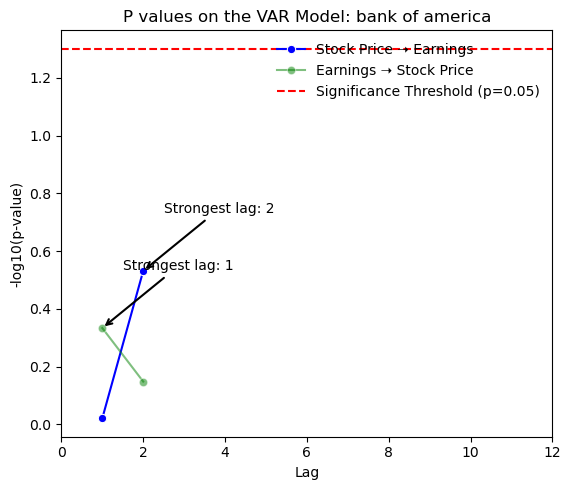

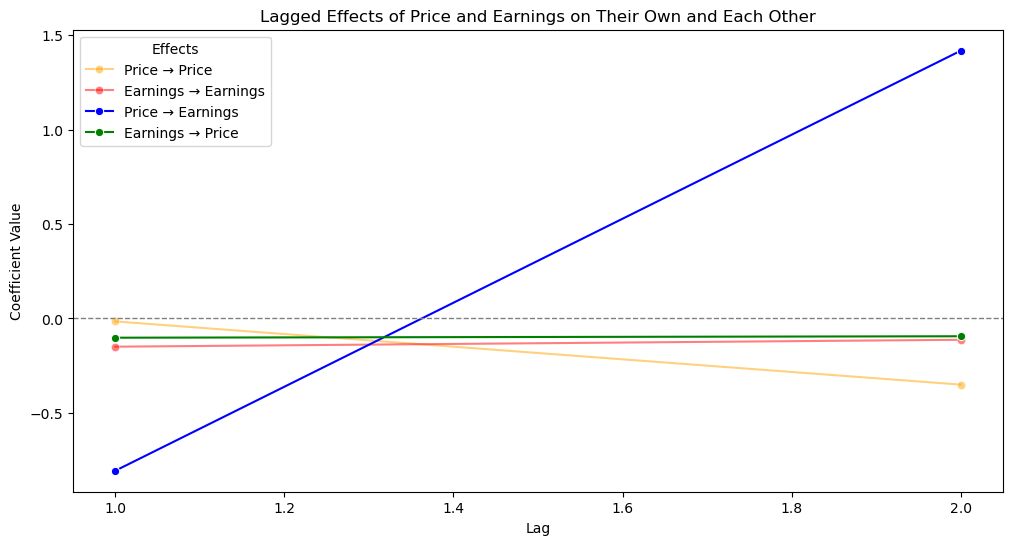

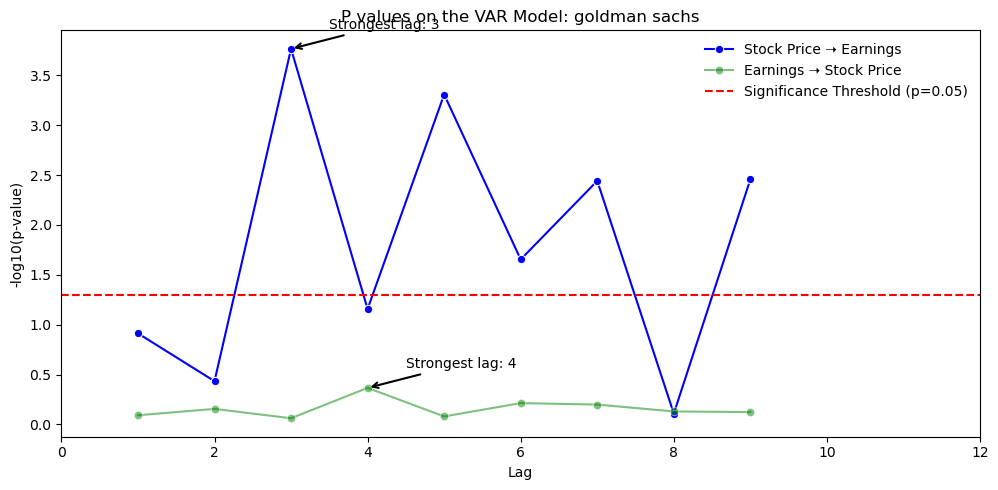

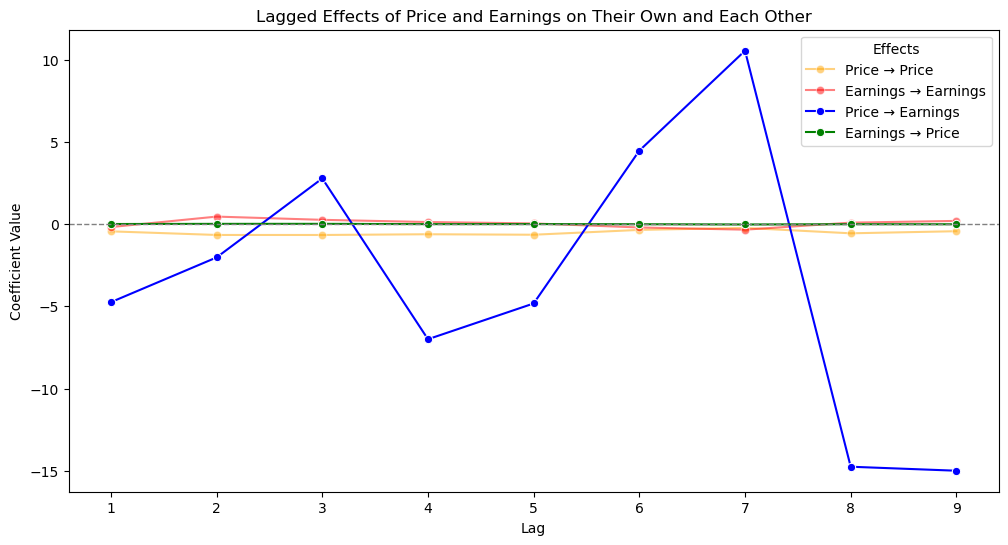

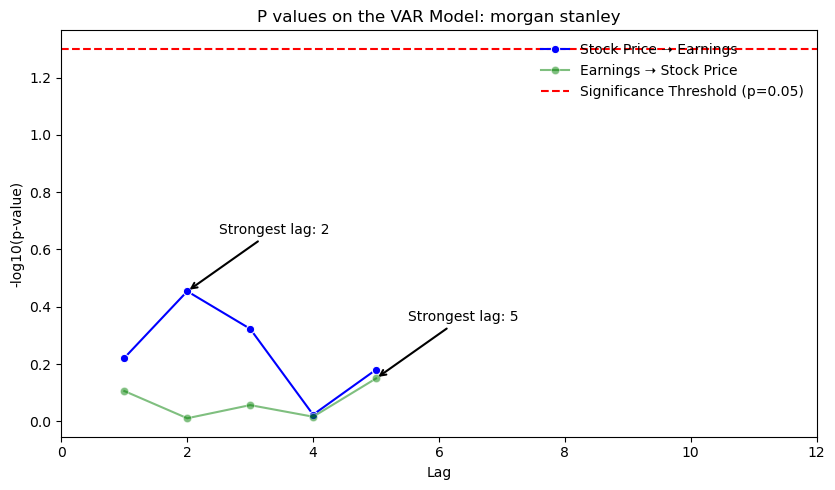

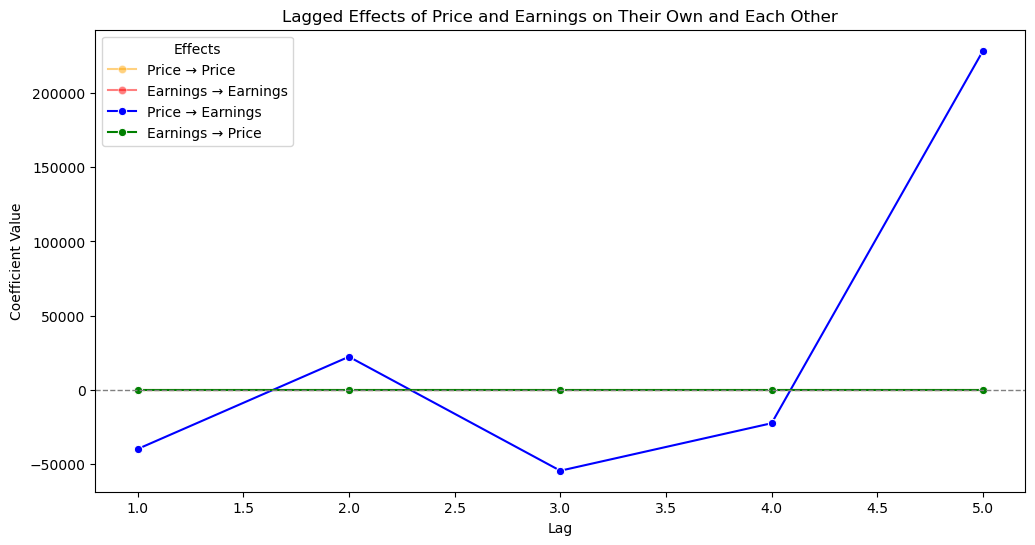

In [196]:
JPM_Quarter_PValues, JPM_Quarter_Coeffs = Quarterly_Price_Earnings_VAR(JPM_quarterly, 'jp morgan')
BAC_Quarter_PValues, BAC_Quarter_Coeffs = Quarterly_Price_Earnings_VAR(BAC_quarterly, 'bank of america')
GS_Quarter_PValues, GS_Quarter_Coeffs = Quarterly_Price_Earnings_VAR(GS_quarterly, 'goldman sachs')
MS_Quarter_PValues, MS_Quarter_Coeffs = Quarterly_Price_Earnings_VAR(MS_quarterly, 'morgan stanley')
#UBS_Quarter_PValues, UBS_Quarter_Coeffs = Quarterly_Price_Earnings_VAR(UBS_quarterly, 'ubs')

#UBS is missing a ot of values/ k=leave out of set